<p align="center">
<img src="https://github.com/datacamp/python-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
</p>
<br><br>

# Python Live Training Template


Welcome to this hands-on training where we will learn to extract meaningful insights and make predictions based on time series data. 

Learn to::

- Identify trends and seasonality in data
- Use correlation analysis to uncover patterns in time series
- Use models like the moving average model and the autoregressive model to make predictions


# The datasets

Time series data is exceptionally varies, as are time series analysis techniques, and it's important to know more than just one technique, so we'll be using several datasets throughout the training. We'll do most work with

- Monthly US gasoline production, in millions of barrels)
- Quarterly unemployment rate in the US

Each dataset will only have two columns:
- `date`: the end date of the period (month or quarter)
- `value`: the value of the quantity


# Getting started

In [66]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm

# Set plot style
plt.style.use('seaborn')

# Set plot size
plt.rcParams['figure.figsize'] = [8,6]

# Preparing the data

For the first part of the training, we'll be using the data containing weekly US gasoline production from 1991-02-03 to 2017-01-15, in million barrels.

##      Loading the data

In [46]:
# Load the data from a CSV file
data = pd.read_csv("/Users/alex/US_gasoline_production.csv")

# Print the DataFrame info
data.info()

# Print the DataFrame
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 2 columns):
date     1355 non-null object
value    1355 non-null float64
dtypes: float64(1), object(1)
memory usage: 21.3+ KB


,date,value
0,1991-02-03,6.621
1,1991-02-10,6.433
2,1991-02-17,6.582
3,1991-02-24,7.224
4,1991-03-03,6.875
...,...,...
1350,2016-12-18,9.278
1351,2016-12-25,8.465
1352,2017-01-01,8.470
1353,2017-01-08,8.069


## Creating a datetime index

The data contains dates in the `date` column, but the column is of type `object`, and it isn't the index of the DataFrame! 

Solutions: 

- Use arguments `parse_dates=[list_of_column_name]` and `index_col="ColumnName"` in `pd.read_csv()`

- Use `pd.to_datetime()` and `.set_index()` after loading the DataFrame 

We'll use the second one.

`pd.to_datetime()` accepts a value or a collection of values and converts them to a `datetime` object.

`data.set_index()` accepts the name of the column that should become the index, and retuns a _new_ DataFrame. 
Specify `inplace=True` to avoid creating a copy

In [97]:
# Convert the date column to datetime
data["date"] = pd.to_datetime(data["date"])

# Set the index of the DataFrame to the date column
data.set_index("date", inplace = True)

# Print DataFrame summary
data.info()

# Print DataFrame
data


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1355 entries, 1991-02-03 to 2017-01-15
Data columns (total 1 columns):
value    1355 non-null float64
dtypes: float64(1)
memory usage: 21.2 KB


,value
date,
1991-02-03,6.621
1991-02-10,6.433
1991-02-17,6.582
1991-02-24,7.224
1991-03-03,6.875
...,...
2016-12-18,9.278
2016-12-25,8.465
2017-01-01,8.470


# Exploratory analysis


## Ploting a time series

...is the easiest kind of plotting in Python: just use `df.colum_name.plot()` !

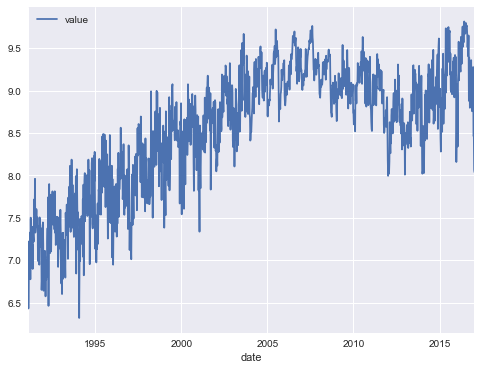

In [98]:
# Plot the series
data.plot()

Notice the style of the plot: it looks different from the default `matplotlib` style. The style was set in the very first cell using `plt.style.use('seaborn')`

The plot looks very noisy. Do we really need _weekly_ data?

## Resampling

<a href="https://learn.datacamp.com/courses/manipulating-time-series-data-in-python"><img src = "https://assets.datacamp.com/production/course_4205/shields/original/shield_image_course_4205_20200406-1-f1geys" width="20%" style="float: right;"></a>
Resampling means changeing the frequency of data:
- **Upsampling** : from lower to higher frequency (daily &rarr; hourly).

- **Downsampling** : from higher to lower frequency (daily &rarr; weekly). 
   
 
 Lower-frequency data is usually aggregated: value for week X is the sum/average/max/min/... of all the daily values in week X.

##### Steps of downsampling:

1. `.resample(rule='M'|'W'|'D'|..)`...

2. aggregate `.mean()`, `.sum()`


In [212]:
# Resample the data to the average monthly values
data_monthly = data.resample("M").mean()

# Print the head of data
print(data.head())

# Print the head of resampled data
print(data_monthly.head())


            value
date             
1991-02-03  6.621
1991-02-10  6.433
1991-02-17  6.582
1991-02-24  7.224
1991-03-03  6.875
              value
date               
1991-02-28  6.71500
1991-03-31  7.08600
1991-04-30  6.97325
1991-05-31  7.19175
1991-06-30  7.61900


The resampled DataFrame contains the last day fo the month for every month, and the corresponding value is the average of values within that month.

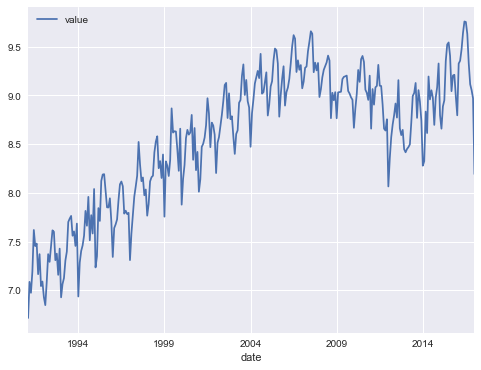

In [68]:
# Plot resampled data
data_monthly.plot()

Looks likesome sort of pattern and also a trend, but both are hard to see. 

Restrict the data to a time range to "zoom in" on the plot:

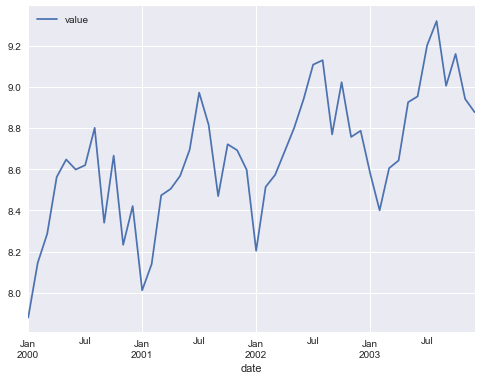

In [69]:
# Plot the data from 2000 to 2003
data_monthly["2000":"2003"].plot()

The same pattern seems to be repeated every year: January has the lowest value, July &mdash; the highest, and there's an additional dip in September.

## Smoothing: rolling windows

Even after resampling, the trends and patterns might be hard to see. 

> **Rolling aggregation** creates a _new_ time series: value for each timestamp is an aggregation of a fixed number of previous values.


<font color = AAAAAA><i>
- Value for today = Average of values since last Tuesday
- Value for yesterday = Average of values since last Monday
- Value for Sunday = Average of values since Sunday before that
- ...
</i></font>
$U_t = \frac{1}{7}(Y_t + Y_{t-1} + Y_{t-2} + Y_{t-3} + Y_{t-4} + Y_{t-5}+ Y_{t-6})$

<!---
|date|original series|rolling window series|
|---|---|---|
|2020-06-02| 5 ||
|2020-06-01| 7 ||
|2020-05-31| 9 ||
|2020-05-30| 11||
|2020-05-29| 13||
|2020-05-28| 15||
|2020-05-27| 17| (17)|
|2020-05-26| 2 | (2+4+6+8+10+12+14)/7|
|2020-05-25| 4 | NaN|
|2020-05-24| 6 | NaN|
|2020-05-23| 8 | NaN|
|2020-05-21| 10 | NaN|
|2020-05-20| 12 |NaN|
|2020-05-20| 14 |NaN|
--->
<br>

<font size = 5> larger window = less detail = more smooth</font>


##### Steps of rolling window smoothing:

1. `.rolling(n_periods)`...

2. aggregate `.mean()`, `.sum()`



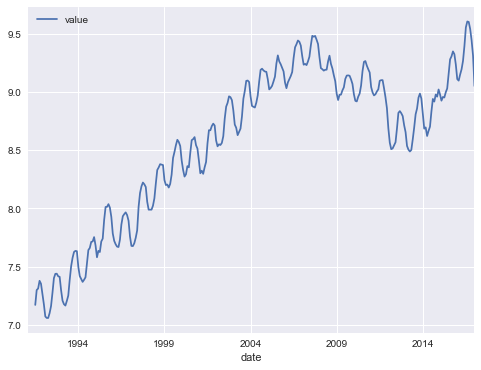

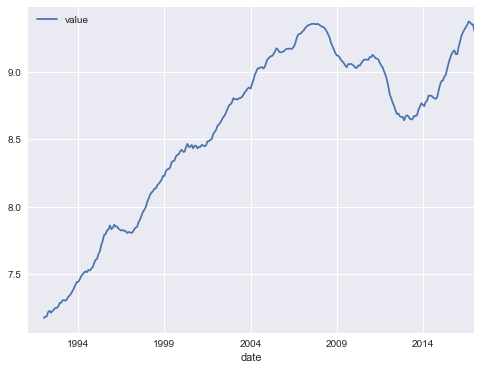

In [70]:
# Plot the resampled data with a 6 months rolling average
data_monthly.rolling(6).mean().plot()

# Plot the resampled data with a 12 months rolling average
data_monthly.rolling(12).mean().plot()

Looks like there was a general increasing trend until 2007-2008, when the value started decreasing. [What happened in 2008?..](https://en.wikipedia.org/wiki/Great_Recession)

---
<img src="attachment:image.png">

<font color="00AAFF" size = 5>Homework</font>

<font color=00AAFF>_Think you are a `pandas` wizard? Try using a rolling window + weighted average on a column where the weights come from another column_ 😉</font>

---

## Time series = Trend + Seasonality + Residuals

    
- **Trend**: general direction of the series (e.g. increasing)
- **Sesonality**: repeating patterns in data (weekends, holidays..)
- **Residuals**: the rest

`statsmodels.tsa.seasonal.seasonal_decompose()` takes a DataFrame and returns an object with attributes:
- `.trend`
- `.seasonal`
- `.resid`
each containing the time series that encodes the corresponding part of the original series, 

and a method
- `.plot()`
which makes 4 plots:  original series + 3 its components

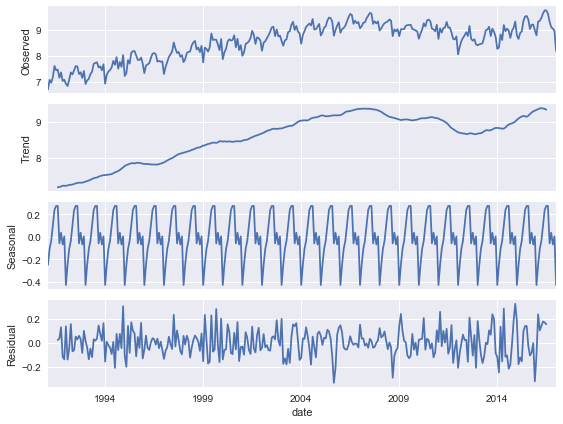

In [71]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot decomposed series
seasonal_decompose(data_monthly).plot();

_Note: plotting functions in `statsmodels` both draw and return the figure, so plotting them from the last line of a cell will result in duplicate plots. USe a semicolon after the plot to prevent that_

## Don't just trust your eyes

A series that exhibits a clear visible trend or seasonality probably really does have those features. But if you cannot detect trend or seasonality with the naked eye, doesn't mean they aren't there!

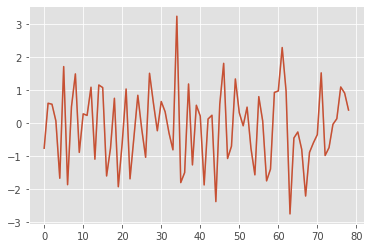

This data lies on a perturbed sine curve. Can you tell?..

_Autocorrelation_ will help us identify hidden patterns in series

---
<center><h1> Q&A 1</h1> </center>

---


# Autocorrelation

For prediction, we need to know how future values of time series depend on the past values.

Correlation of two _random variables_ is a measure of dependency of one variable on the other. For time series, _auto_correlation, as the name might suggest, will measure self-correlation &mdash; the dependency of time series on itself.


## Lags

Lagged time series is just the same time series shifted by a certain number of days/weeks/month, called the _lag_, into the past:

|date|original series|lag-2 series|
|---|---|---|
|2020-05-01| 5 |NaN|
|2020-05-02| 7 |NaN|
|2020-05-03| 9 |5|
|2020-05-04| 11|7|
|2020-05-06| 13|9|
|2020-05-07| 15|11|
|2020-05-08| 17| 13|
|2020-05-08| 2 | 15|
|2020-05-10| 4 | 17|
|2020-05-11| 6 | 2|
|2020-05-12| 8 | 4|
|2020-05-13| 10 | 6|
|2020-05-14| 12 |8|
|2020-05-15| 14 |10|

Notice the `NaN`s! The bigger the lag is, the shorter the lagged series will be.

## Autocorrelation function
Function of the lag $\mathbf{n}$. 

$$\large{Autocorr(\mathbf{n}) = corr(series, \,lag\,\mathbf{n}\, series)}$$

Measures how much the value of the series now depends on the value $\mathbf{n}$ days ago.


`statsmodels` offers two functions related to autocorrelation:
- `statsmodels.tsa.stattools.acf()`  will compute the ACF ACF for a time series passed to it, with 40 lags range bt default
- `statsmodels.graphics.tsaplots.plot_acf()` will just plot the ACF -- which is usually what we want


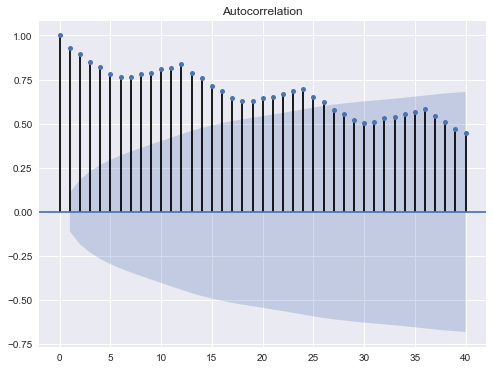

In [72]:
# Import plot_acf
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF of data_monthly
plot_acf(data_monthly, lags = 40);


The lags are on the $x$ axis. Note that lag-0 correlation is always 0.

The filled band around the $x$ axis is the _confidence interval_: if the autucorrelation value is outside that range, the dependency is likely "real", but if it's inside &mdash; it's likely due to randomness.

## A word of warning: misinterpreting autocorrelation

The autocorrelation seems to be very strong: does that mean there's very strong dependency between past and present value that we can use for modeling? Let's take a look at the data again:

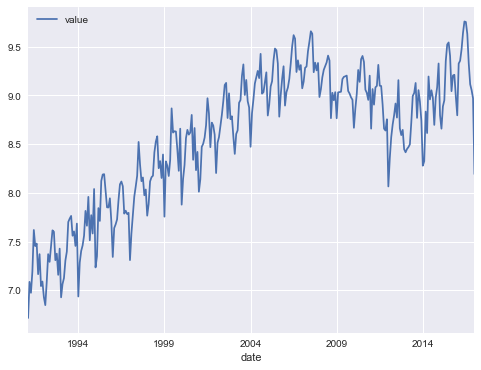

In [75]:
# Plot data_monthly again
data_monthly.plot()

The series show a strong trend, and that's what autocorrelation plot reflects: if the series was going up last e.g. 6 months, it will probaby continue going up for the next month or two.

_Autocorrelation in series with trends reflects the trend rather than intrinsic dependencies in data._

# Stationarity

Most time series models assume that the time series is _stationary_. In plain language, that means that the features of the series do not depend on the _time_ when they occur (but they might depend on the past _values_). This means, among other things:

- Constant mean
- Contant variance

**Time series that exhibit trend and seasonality are not stationary.**

Most time series models assume stationarity of the series they model, so you often need to remove trend and seasonality from the series, build the model, then put it back.


## Detrending

- Fit the trend curve first

For example, for a linear trend, use linear modeling techniques to find the fit, then subtract it from the series 
Learn more in Introduction to Linear Modeling in Python

- Differencing
Instad of looking at the actual values of the series look at the _differences_ in values.

$U_t = Y_{t} - Y_{t-1}$

Here's an example:

|date|original series|differenced series|
|---|---|---|
|2020-05-01| 5 |NaN|
|2020-05-02| 7 |7-5 = **2**|
|2020-05-03| 8 |8-7 = **1**|
|2020-05-04| 8|8-8 = **0**|
|2020-05-06| 9|9 - 8 = **1**|

The original series is growing, but the differences aren't. 


`pandas` method `.diff()` can be used to difference the series.

- Other transformations

Returns and log-returns, $\log{\frac{Y_t - Y_{t-1}}{Y_t}}$, are also commonly used in modeling stock prices. 


In [76]:
# Difference data_monthly
data_monthly_diff = data_monthly.diff()

# Show differenced values
data_monthly_diff.head()

,value
date,
1991-02-28,NaN
1991-03-31,0.37100
1991-04-30,-0.11275
1991-05-31,0.21850
1991-06-30,0.42725


Notice the first value is `NaN` because there was nothing to subtract from the first value of the original series.

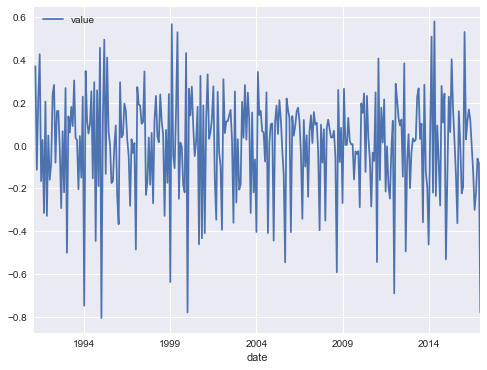

In [77]:
# Plot differenced data

data_monthly_diff.plot()

The trend disappeared! The series appears more stationary now.

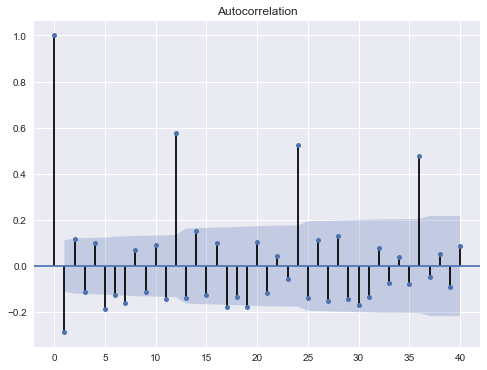

In [81]:
# Plot ACF for differenced data
plot_acf(data_monthly_diff.dropna(), lags=40);

We still see large autocorrelation at 12, 24, 36 etc lags, but this is due to seasonality: the data had a yearly pattern.

Here autocorrelation again doesn't expose anything too useful: if every January the production goes down, of course the values recorded this January will be correlated with values from last January!


## Dealing with seasonality

Dealing with seasonality is much more complicated. Many organizations (e.g. US Census Bureau) have developed their own methods for removing seasonality from data.

Some things you can do yourself:

- _Model within one period_

If you're only using data from 14 days in June, does it matter if there's a yearly seasonal spike around winter hoidays?..

- _Use seasonaly-adjusted data_

For example, most US government agencies provide seasonaly-adjusted data by default.

- _Do seasonal adjustment yourself_

  - Use higher-order differencing
  - Use the residuals from `seasonal_decompose()`, contained in the `.resid` attribute
  - Special techniques like [STL](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html)

- _Use special models like Seasonal ARIMA (SARIMA)_

INSERT PIC OF ARIMA MODELING IN PYTHON


               value
date                
1991-02-28       NaN
1991-03-31       NaN
1991-04-30       NaN
1991-05-31       NaN
1991-06-30       NaN
1991-07-31       NaN
1991-08-31  0.022702
1991-09-30  0.034589
1991-10-31  0.128719
1991-11-30 -0.115517
               value
date                
2016-04-30  0.137950
2016-05-31  0.176393
2016-06-30  0.168386
2016-07-31  0.153326
2016-08-31       NaN
2016-09-30       NaN
2016-10-31       NaN
2016-11-30       NaN
2016-12-31       NaN
2017-01-31       NaN


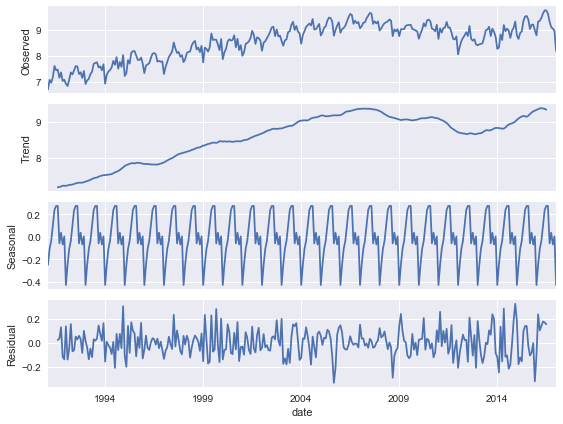

In [163]:
# Plot seasonal decomposition of data_monthly again
seasonal_decompose(data_monthly).plot()

# Extract residuals and save
data_monthly_resid = seasonal_decompose(data_monthly).resid

# Print the head and tail of the residual compomnent
print(seasonal_decompose(data_monthly).resid.head(10))
print(seasonal_decompose(data_monthly).resid.tail(10))

The residual component of `seasonal_decomplose` will have the first few and last few values missing because `statmodels` uses rolling avegage to identify trends and residuals.

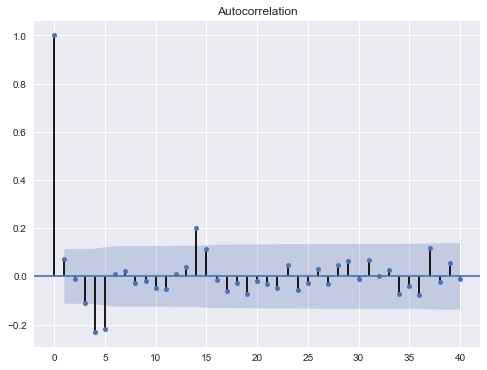

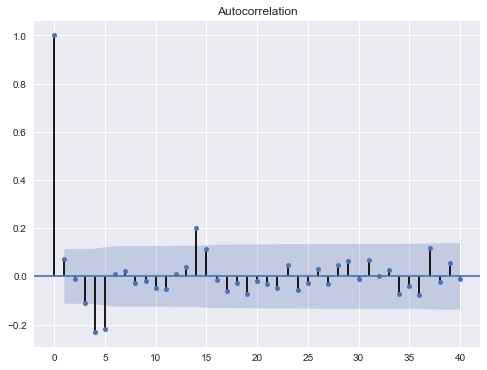

In [164]:
# Drop NaN values from residuals
data_monthly_resid = data_monthly_resid.dropna()

# Plot ACF of the residual component of data_monthly
plot_acf(data_monthly_resid, lags=40)

The seasonal patterns have been (mostly) removed. After the data is modelled, the `.seasonal` component can be added back to the series.


---
<font color="00AAFF" size = 5>**Homework**</font>


1. <font color=00AAFF>Use `df.shift()` and `df.corr()` to implement the autocorrelation function yourself.</font>


2. <font color=00AAFF>It's pretty easy to tell when a series is non-stationary if it has trend or seasonality. It's harder to claim that a series that _appears_ stationary truly _is_ stationary. Learn about the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) for stationarity and [`statsmodels.tsa.stattools.adfuller()`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)</font>

---

---
<center><h1> Q&A 2</h1></center>

---

# Time series models

This section is going to have some math formulas in it, but don't worry: the intuitions are pretty simple! If you don't understand formulas fully, that shouldn't stop you from modeing!


## Two basic models

#### 1. White noise

> The best model for a future value is just a constant mean

$$\large{value\_today = mean + noise\_today}$$
<br>
$$Y_t = \mu + \varepsilon_t$$



This time series just oscillates aroung the mean: 

PIC HERE


#### 2. Random walk

> The best model for a future value is the previous value

$$\large{value\_today = value\_yesterday + noise\_today}$$
<br>
$$Y_t = Y_{t-1} + \varepsilon_t$$


This time series drifts randomly:

PIC HERE


## Moving average (MA) model

Shocks/noise/errors from a few days ago can still impact the series today: for example a particularly big market shock can persist for days.  We can improve the white noise model slighly by taking into account the previous errors.

$$MA(q): \large{value\_today = mean + avg(past \, \mathrm{q} \,noises)}$$

$$Y_t = \mu + \varepsilon_t + \phi_1 \varepsilon_{t-1} + \phi_2 \varepsilon_{t-2} +...+ \phi_q \varepsilon_{t-q} $$

"Average" means "weigthed average", with weights $\phi_i$ possibly diminishing as we go farther in the future.

### Detecting MA model order

$MA(q)$ only contains information about the past $q$ time periods, so there should be no significant autocorrelation after $q$ lags.

Consequently, $MA(q)$ models are suitable for modeling time series with ACF that "stops" at a certain point.

Some idealized examples:


INSERT PICTURES

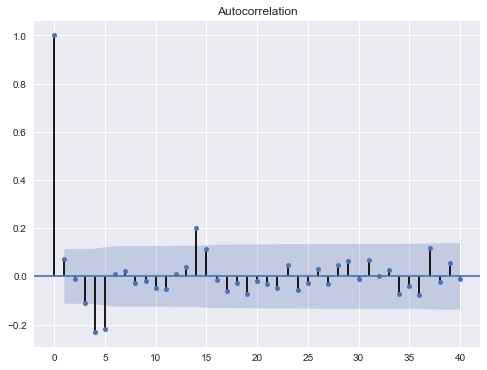

In [175]:
# Plot ACF of residuals again 
plot_acf(data_monthly_resid, lags = 40);

While the pattern is not as clear as on the idealized example, we could say that after lag 5, autocorrelation is basically non-existent.

So we'll fit an $MA(5)$ model.

### Fitting MA(q) model

`statsmodels.tsa.arima_model.ARMA` is a class representing a general ARMA model 
(ARMA = AR + MA, where AR is "autoregressive". We'll get to it in a sec!)

1. **Create the model**

`statsmodels.tsa.arima_model.ARMA(series_here, order=(p,q))` will create the model object.

To specify an $MA(q)$ model, pass `order = (0,q)`


2. **Fit the model**

`model.fit()` will fit the model and return the results object.


In [180]:
# Import ARMA
from statsmodels.tsa.arima_model import ARMA

# Fit the model to data_monthly_diff
model = ARMA(data_monthly_resid, order=(0,5))
result = model.fit()


Use `result.summary()` to view information about the model fit: 

In [181]:
# Print summary of the model
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  300
Model:                     ARMA(0, 5)   Log Likelihood                 262.537
Method:                       css-mle   S.D. of innovations              0.100
Date:                Mon, 01 Jun 2020   AIC                           -511.073
Time:                        13:56:41   BIC                           -485.147
Sample:                    08-31-1991   HQIC                          -500.698
                         - 07-31-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003      0.000      1.284      0.200      -0.000       0.001
ma.L1.value    -0.1085      0.058     -1.859      0.064      -0.223       0.006
ma.L2.value    -0.1208      0.057     -2.109      0.036      -0.233      -0.009
ma.L3.value    -0.2123      0.050     -4.223      0.000      -0.311      -0.114
ma.L4.value    -0.3181      0.062     -5.171      0.000      -0.439      -0.198
ma.L5.value    -0.2403      0.055     -4.359      0.000      -0.348      -0.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.1753           -1.2946j            1.3065           -0.2286
MA.3            0.1753           +1.2946j            1.3065            0.2286
MA.4           -1.3372           -0.8062j            1.5614           -0.4136
MA.5           -1.3372           +0.8062j            1.5614            0.4136
-----------------------------------------------------------------------------
"""

### Predicting with MA(q) model

- `result.predict(start=..., end=...)`

Will return predictions from the `start` date to the `end` date. Can give in-sample and out-sample predictions.

For in in-sample dates, one-step-ahead prediction will be made by default, i.e. in-sample  values are used for prediction instead of previous forecasts. 


- `result.plot_predict(start=..., end=...)`

Will plot predictions from the `start` date to the `end` date. For out-of-sample predictions, a confidence interval will be shown as well.

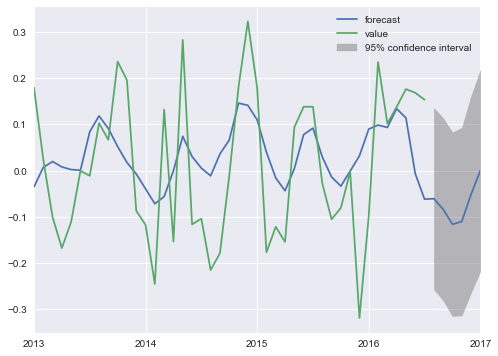

In [186]:
result.plot_predict(start="2013-01-31", end="2017-01-31");

It isn't a great forecast, but it also isn't bad, especially for such a simple model: it accurately predicts the direction of the change, but it underestimates the magnitude.

---
<center><h1>Q&A 3</h1></center>

---


# New dataset

In this section, we'll work with the `US unemployment` dataset from the US Census Bureau, containing quarterly data on the % of people unemployed in the US. The data has been _seasonally adjusted_ already.

Let quickly plot it and de-trend it using differencing.



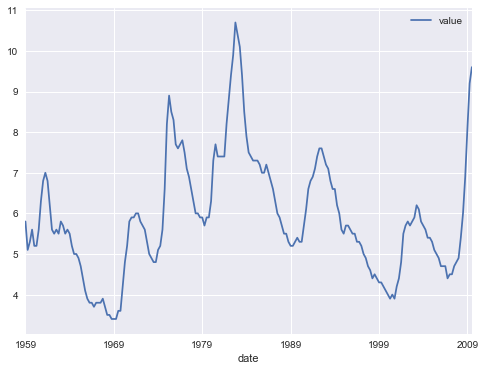

In [189]:
# Load the unemployment data and set index
unemployment = pd.read_csv("/Users/alex/US_unemployment.csv")
unemployment["date"] = pd.to_datetime(unemployment["date"])
unemployment.set_index("date", inplace=True)

# Plot the data
unemployment.plot()


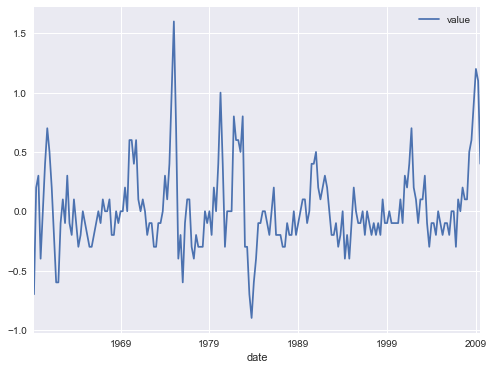

In [190]:
# Difference the data
unemployment_diff = unemployment.diff().dropna()

# Plot the differenced data
unemployment_diff.plot()


## Autoregressive model

Model future value not just by a single past value, but by several past values (instead of past _residuals_, like in $MA(q)$ model:

$$AR(p): \large{value\_today = mean + avg(past \, \mathrm{p} \, values) + noise\_today}$$

$$Y_t = \mu + \theta_1 Y_{t-1} + \theta_2 Y_{t-2} + \dots + \theta_p Y_{t-p} + \varepsilon_t$$ 

where average is, again, a weighted average. How far in the past the model goes, i.e. the value of $p$, is the _order_ of the model. The model is usually denoted AR(p).

Low orders are the most common: $AR(1)$, $AR(2)$,.. 

$$ \text{AR(1): }Y_t = \mu + \theta Y_{t-1} + \varepsilon_t $$

When $\theta = 1$, this is a _random walk_ model. When $\theta \geq 1$, the process is not stationary: the variance increases.



### Detecting model order

Unlike in the $MA(q)$ model, in $AR(p)$ models of any order, the current value depends on _all_ the past values:
$$
\begin{align}
Y_t = \mu + \theta \color{red}{Y_{t-1}} + \varepsilon_t &= \mu + \theta \color{red}{(\mu + \theta {Y_{t-2}} + \varepsilon_{t-1})} + \varepsilon_t\\
\\
\mu + \theta \color{red}{(\mu + \theta \color{blue}{Y_{t-2}} + \varepsilon_{t-1})} + \varepsilon_t &=\mu + \theta \color{red}{(\mu + \theta \color{blue}{(\mu + \theta {Y_{t-3}} + \varepsilon_{t-2})} + \varepsilon_{t-1})} + \varepsilon_t = \\ 
\\
\mu + \theta \color{red}{(\mu + \theta \color{blue}{(\mu + \theta \color{magenta}{{Y_{t-3}}} + \varepsilon_{t-2})} + \varepsilon_{t-1})} + \varepsilon_t &= \dots
\end{align}
$$

When $|\theta_i| < 1$, the dependency will dimish as we go further and further into the past:

$$AR(1) : Y_{t} = constant + \theta Y_{t-1} + \theta^2 Y_{t-2} + \theta^3 Y_{t-3}  + \dots $$

So the autocorrelation function does not "stop" &mdash; it just decreases to 0. 

Here's an idealized example:

PIC HERE



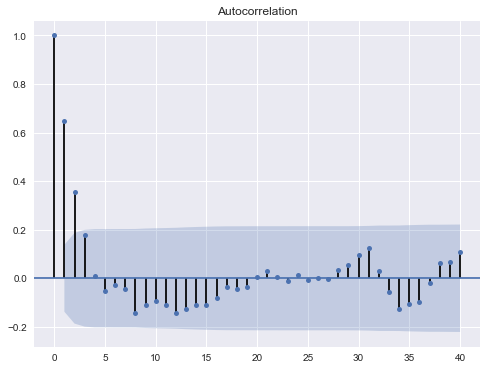

In [193]:
# Plot ACF for unemployment_diff

plot_acf(unemployment_diff, lags=40);

The value of autocorrelation oscillates between negative and positive, but the magnitude is decreasing

#### Partial autocorrelation function

Partial autocorrelation function is a modified autocorrelation function that takes into account dependencies betweed previous lags, and removes extraneous dependencies shown in the correlation function.

- `statsmodels.tsa.stattools.pacf()` will return values of the PACF
- `statsmodels.graphics.tsaplots.plot_pacf()` will show the plot of the PACF

For time series that behave like an $AR(p)$ process, the PACF "stops" at a certain lag. That lag can serve as the model order.

Here's an idealized example:

PIC HERE

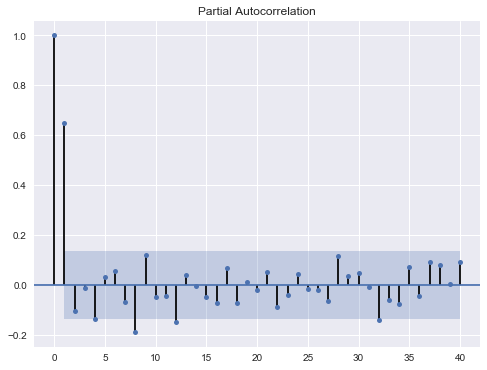

In [199]:
# Import
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(unemployment_diff, lags=40);

Unlike with the ACF plot, there's no gradual decrease after lag 1.

### Fitting AR(p) model

`statsmodels.tsa.arima_model.ARMA` is a class representing a general ARMA model 
(ARMA = AR + MA, where AR is "autoregressive", "MA" is "moving average")

1. **Create the model**

`statsmodels.tsa.arima_model.ARMA(series_here, order=(p,q))` will create the model object.

_To specify an $AR(p)$ model, pass `order = (p,0)`_


2. **Fit the model**

`model.fit()` will fit the model and return the results object.


In [201]:
# Import ARMA
from statsmodels.tsa.arima_model import ARMA

# Fit the model to unemployment_diff
model = ARMA(unemployment_diff, order=(1,0))
result = model.fit()

# Print the summary
result.summary()

/Users/alex/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  202
Model:                     ARMA(1, 0)   Log Likelihood                 -14.289
Method:                       css-mle   S.D. of innovations              0.259
Date:                Mon, 01 Jun 2020   AIC                             34.578
Time:                        14:10:25   BIC                             44.503
Sample:                    06-30-1959   HQIC                            38.594
                         - 09-30-2009                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0156      0.053      0.293      0.770      -0.089       0.120
ar.L1.value     0.6612      0.054     12.346      0.000       0.556       0.766
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5125           +0.0000j            1.5125            0.0000
-----------------------------------------------------------------------------
"""

### Predicting with AR(p) model

Same as for $MA(q)$ model:

- `results.predict(start=..., end=...)`

Will return predictions from the `start` date to the `end` date. Can give in-sample and out-sample predictions.

For in in-sample dates, one-step-ahead prediction will be made by default, i.e. in-sample  values are used for prediction instead of previous forecasts. 


- `results.plot_prediction(start=..., end=...)`

Will plot predictions from the `start` date to the `end` date. For out-of-sample predictions, a confidence interval will be shown as well.


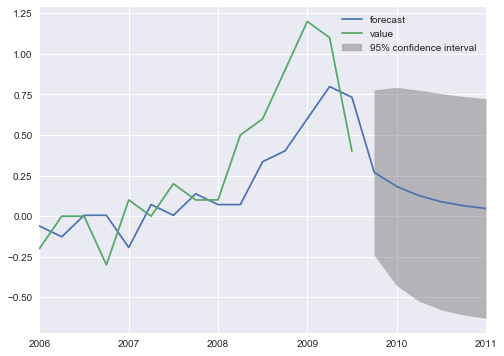

In [211]:
result.plot_predict(start="2006-03-31", end="2011-03-31");

---
<center><h1>Q&A 4</h1><center>

---